# Techniques of High Performance Computing - Assignment 3

**Name: John Duffy**

**Student Number: 19154676**

## Import Libraries Common to Question 1 & 2

In [ ]:
# Import libraries common to Questions 1 & 2.

import numpy as np
import pyopencl as cl

from scipy.sparse.linalg import LinearOperator, cg

#from scipy.sparse import dia_matrix, csr_matrix, eye, rand
#from scipy.sparse.linalg import LinearOperator, cg

# Question 1

## Investigating Splitting Schemes

### Program Description

#### Jacobi Iteration


#### Gauss-Seidel Iteration


### Program Structure

#### Jacobi Iteration

##### The init Method

##### The matvec Method

##### The OpenCL Kernel

The OpenCL kernel takes the following as parameters:

- **const int m** The number of rows of the sparse matrix
- **const int n** The number of columns of the sparse matrix
- **__global const double \*data** A pointer to the sparse matrix data array stored in device global memory
- **__global const double \*indices** A pointer to the sparse matrix indices array stored in device global memory
- **__global const double \*indptr** A pointer to the sparse matrix indices pointer array stored in device global memory
- **__global const double \*u** A pointer to the input vector array stored in global memory
- **__global double \*v** A pointer to the output vector stored in global memory


#### Gauss-Seidel Iteration


### Performance Testing


#### Dense Matrix


#### Sparse Matrix



## Class DiscreteLaplacian

In [ ]:
# Define the OpenCL kernel string used in the class DiscreteLaplacian. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void discrete_laplacian(const int m, __global const float *u, __global float *v)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Don't change the boundary conditions.
    
    if (r == 0 || r == (m - 1) || c == 0 || c == (m - 1)) {
        v[m * r + c] = u[m * r + c];
        return;
    } 
    
    // Implement the averaging formula for the interior points.

    v[m * r + c] = (u[m * (r + 1) + c] + u[m * (r - 1) + c] + u[m * r + (c + 1)] + u[m * r + (c - 1)]) / 4.0f;
}

"""


# Define the class DiscreteLaplacian.

class DiscreteLaplacian(LinearOperator):
    """
    """
    
    def __init__(self, m):
        """
        """
        
        # Store the size m as an instance variable for access by class methods.
        
        self._m = m
        
        
        # Attributes required to be declared by LinearOperator.
        
        self.shape = (m * m, m * m)
        
        self.dytpe = np.float32
        

        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Note: u is READ_ONLY and v is WRITE_ONLY.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        
        self._v = cl.Buffer(self._ctx, cl.mem_flags.WRITE_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().discrete_laplacian

    
    def _matvec(self, u):
        """
        """

        # Use mapped input to efficiently copy the input vector u to the device.
        
        mapped_input, _ = cl.enqueue_map_buffer(self._queue, self._u, cl.map_flags.WRITE, 0, self._m * self._m, np.float32)
        
        with mapped_input.base:
            mapped_input[:] = u.astype(np.float32)


        # Run the kernel across all grid points in parallel using a global workspace m x m. 
            
        self._kernel(self._queue, (self._m, self._m), None, np.int32(self._m), self._u, self._v)


        # Create an output vector v and copy the output from the device.
                     
        v = np.zeros((self._m, self._m), dtype=np.float32)

        cl.enqueue_copy(self._queue, v, self._v)
                     

        # Return v as the correct datatype.
            
        return v.astype(np.float32)

In [ ]:
# Test the class DiscreteLaplacian.

M = 5

# Generate test data with boundary conditions as per Question 1.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

print(u)

laplacian = DiscreteLaplacian(M)

v = laplacian(np.ascontiguousarray(u.flatten())).reshape(M, M)

print(v)

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot(z):
    plt.imshow(z, origin='upper')
    plt.colorbar()
    plt.show()

plot(u)
plot(v)

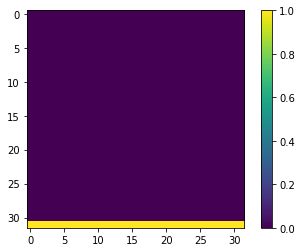

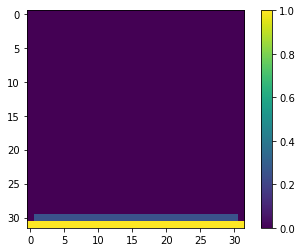

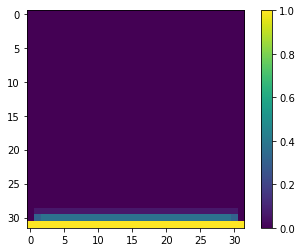

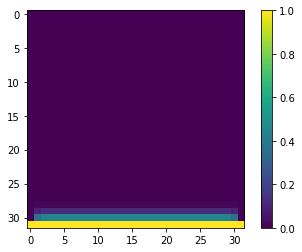

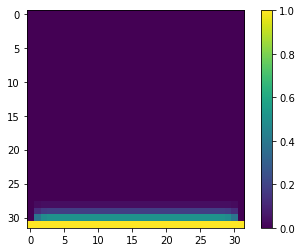

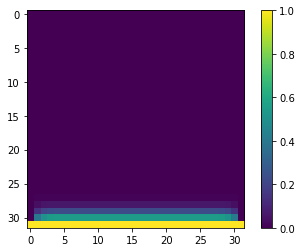

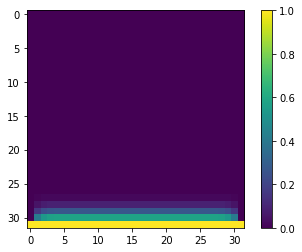

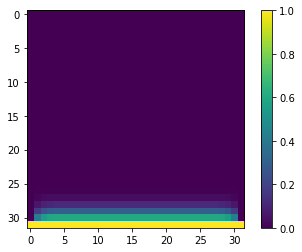

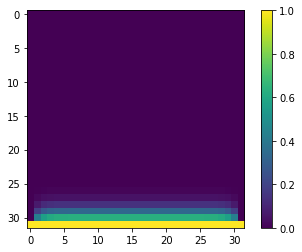

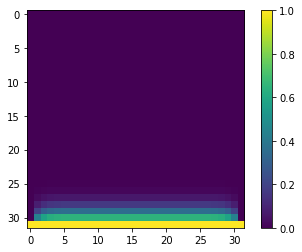

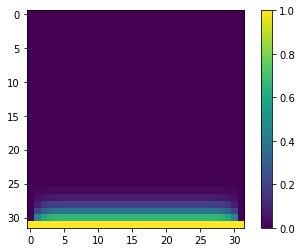

In [198]:
# Repeated call...

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

plot(u)

laplacian = DiscreteLaplacian(M)

for _ in range(10):
    v = laplacian(u.flatten()).reshape(M, M)
    plot(v)
    u = v

# Question 2

## Preconditioned Iterative Solvers

### Program Description

### Program Structure

### Performance Testing
